# Roshambo game : offline preliminary analysis

## Load the recorded data 

In [57]:
filenames = ['clem_allonge_20221029-192231.hdf5','clem_assis_20221029-200201.hdf5','delph_allongee_20221029-170143.hdf5',
            'delph_allongee_20221029-171117.hdf5','delph_assis_20221029-202757.hdf5','othmane_assis_ECG_20221029-223628.hdf5',
            'othmane_assis_EEG_20221029-231521.hdf5']

In [58]:
import pandas as pd
import json

df_filtered, events = pd.DataFrame(), pd.DataFrame()

for f in filenames:
    fname = f'data/{f}'
    df_filtered = pd.concat([df_filtered, pd.read_hdf(fname, "/filtered").merge(pd.read_hdf(fname, "/bands"), how='inner', left_index=True, right_index=True)])
    events = pd.concat([events, pd.read_hdf(fname, "/events")])

for ff, tt in [['"rapide"', '"agite"'],['"lent"', '"calme"']]:
    events.data = events.data.apply(lambda d: d.replace(ff,tt))

events = events.loc[events.data.isin(['"repos"','"calme"','"agite"'])]
classes = events.data.unique()

events['data'] = events.data.apply(lambda d: json.dumps({"id":d}))

df_filtered.sort_index(inplace = True)
events.sort_index(inplace = True)
events.shape, df_filtered.shape, classes

((100, 2), (5092, 6), array(['"repos"', '"calme"', '"agite"'], dtype=object))

## Implement the estimator to extract the features 

In [59]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array

class EMGFeatures(BaseEstimator, TransformerMixin):
    """EMG Temporal features"""
    def fit(self, X, y=None):
        """"""
        return self

    def transform(self, X):
        """Extract EMG temporal features
        Parameters
        ----------
        X : ndarray, shape (n_trials, n_samples, n_channels)
            Data to extract features from
        Returns
        -------
        features : ndarray, shape (n_trials, n_features)
            Temporal features
        """
        X = check_array(X, allow_nd=True)
        shapeX = X.shape

        if len(shapeX) == 3:
            Nt, Ns, Ne = shapeX
        else:
            raise ValueError("X.shape should be (n_trials, n_samples, n_electrodes).")
        
        features = np.hstack([np.max(X, axis=1), np.std(X, axis=1), np.apply_along_axis(self._zero_crossing_rate, 1, X)])
        return features

    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : ndarray, shape (n_trials,  n_samples, n_channels)
            Data to extract features from
        y : ndarray, shape (n_trials,) | None, optional
            labels corresponding to each trial, not used (mentioned for sklearn comp)
        Returns
        -------
        X : ndarray, shape (n_trials, n_features)
            Temporal features
        """
        self.fit(X, y)
        return self.transform(X)
    
    @staticmethod
    def _zero_crossing_rate(x):
        return len(np.where(np.diff(np.sign(x)))[0]) / len(x)

In [60]:
from timeflux.nodes.epoch import Epoch
after, before = -3.0, 25.0

epoch = Epoch(before=before, after=after, event_trigger="start")
epoch.i.data = df_filtered
epoch.i_events.data = events
epoch.update()

In [61]:
epochs = []
labels = []
for port_name, _, port in epoch.iterate():
    label = port.meta.get("epoch", {}).get("context", {}).get("id")
    if label:
        epochs.append(port.data) 
        labels.append(label)

In [62]:
X = np.stack([epoch.values for epoch in epochs  if epoch.values.shape == (int(after+before),6)])
print(X.shape)
features = EMGFeatures().transform(X)
# df_features = pd.DataFrame(features, columns=["A1_max", "A2_max", "A1_std", "A2_std", "A1_zcr", "A2_zcr"])
df_features = pd.DataFrame(features, columns=[f'{f}_{i}' for i in range(3) for f in df_filtered.keys()])
df_features["label"] = [label for idx, label in enumerate(labels) if [epoch.values.shape == (int(after+before),6) for epoch in epochs][idx]]

(89, 22, 6)


## Visualize the features distributions

In [63]:
import seaborn as sns
# _=sns.pairplot(df_features, hue='label')  

## See how it classifies the classes 

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

pipeline = Pipeline(
  steps=[
    ('features', EMGFeatures()),
    ('norm', Normalizer()),
    # ('classifier', KNeighborsClassifier())
    # ('classifier', KMeans(n_clusters=len(classes), init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0))
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric=['error','logloss','auc'], objective='binary:logistic' if len(classes) == 2 else 'multi:softproba', n_estimators=2500, max_depth=7, reg_alpha=1e-4, n_jobs=-1))
  ]
)

In [65]:
label_encoder = {label: code for code, label in enumerate(set(df_features.label))}
y = np.array([label_encoder[label] for label in df_features.label.values])

# fit on first 12, and predict last 8
n_train = int(len(X)*.8)
pipeline.fit(X[:n_train,:], y[:n_train])
y_pred = pipeline.predict(X[n_train:, :])
try: y_score = pipeline.predict_proba(X[n_train:, :])
except: y_score=None
y_true = y[n_train:]

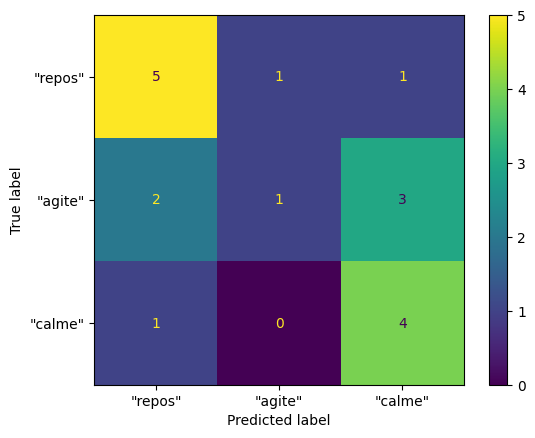

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
_=ConfusionMatrixDisplay(cm, display_labels=list(label_encoder.keys())).plot()

In [67]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, \
                            precision_score, recall_score, log_loss, average_precision_score, auc, roc_curve
from scipy import stats

def accuracy_classification_report(y_test, y_pred, y_score, classes, msg = '', filename=''):
  confusion_mtx = {
                    'y_Actual': np.array(y_test),
                    'y_Predicted': y_pred
                }

  confusion_df = pd.DataFrame(confusion_mtx, columns=['y_Actual','y_Predicted'])    

  metrics = {}

  metrics['spearmanr']       = 100 * (stats.spearmanr(confusion_df['y_Actual'], confusion_df['y_Predicted']))[0]
  metrics['accuracy']        = 100 * accuracy_score(confusion_df['y_Actual'], confusion_df['y_Predicted'])
  if len(np.unique(confusion_df['y_Actual']))== 2:
    metrics['auc score']       = 100 * roc_auc_score(confusion_df['y_Actual'], y_pred, average='macro')
  else:
    metrics['auc score']       = -1 if y_score is None else 100 * roc_auc_score(confusion_df['y_Actual'], y_score, multi_class='ovr', average='macro')
  metrics['log loss']        = -1 if y_score is None else 100 * log_loss(confusion_df['y_Actual'], y_score)
  metrics['precision score'] = 100 * precision_score(confusion_df['y_Actual'], confusion_df['y_Predicted'], average='macro')
  metrics['recall score']    = 100 * recall_score(confusion_df['y_Actual'], confusion_df['y_Predicted'], average='macro')
  metrics['f1 score']        = 100 * f1_score(confusion_df['y_Actual'], confusion_df['y_Predicted'], average='macro')

  output_metrics  = f"Spearmnr score (っಠ‿ಠ)っ\t{metrics['spearmanr']:.2f}\n"
  output_metrics += f"Accuracy Score         :\t{metrics['accuracy']:.2f}\n"
  output_metrics += f"auc score              :\t{metrics['auc score']:.2f}\n"
  output_metrics += f"log loss               :\t{metrics['log loss']:.2f}\n"
  output_metrics += f"precision score        :\t{metrics['precision score']:.2f}\n"
  output_metrics += f"recall score           :\t{metrics['recall score']:.2f}\n"
  output_metrics += f"f1 score               :\t{metrics['f1 score']:.2f}\n\n"
  output_metrics += f"{classification_report(confusion_df['y_Actual'], confusion_df['y_Predicted'], target_names=classes)}"

  print(f'\n==================     {msg}    ================\n\n\033[96m{output_metrics}\033[0m')

  return metrics

_ = accuracy_classification_report(y_true, y_pred, y_score, classes, msg = 'Metrics Report')


==================     Metrics Report    ================

Spearmnr score (っಠ‿ಠ)っ	51.30
Accuracy Score         :	55.56
auc score              :	58.37
log loss               :	118.38
precision score        :	54.17
recall score           :	56.03
f1 score               :	51.07

              precision    recall  f1-score   support

     "repos"       0.62      0.71      0.67         7
     "calme"       0.50      0.17      0.25         6
     "agite"       0.50      0.80      0.62         5

    accuracy                           0.56        18
   macro avg       0.54      0.56      0.51        18
weighted avg       0.55      0.56      0.51        18

